In [ ]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")


All done


In [ ]:
import os

# Define the paths
Path_data = 'C:/Users/ARNAB/Desktop/Process'
Healthy = os.listdir(Path_data + '/Healthy')
Mild = os.listdir(Path_data + '/Mild DR')
Moderate = os.listdir(Path_data + '/Moderate DR')
Proliferate = os.listdir(Path_data + '/Proliferate DR')
Severe = os.listdir(Path_data + '/Severe DR')

# You can now use these lists as needed in your code


In [ ]:
print("classes names :", os.listdir(Path_data), "\n______________________________\n")
print("Number of classes :", len(os.listdir(Path_data)), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")


classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [ ]:
# Define new paths
Path_data = 'C:/Users/ARNAB/Desktop/Process'
Healthy = os.listdir(Path_data + '/Healthy')
Mild = os.listdir(Path_data + '/Mild DR')
Moderate = os.listdir(Path_data + '/Moderate DR')
Proliferate = os.listdir(Path_data + '/Proliferate DR')
Severe = os.listdir(Path_data + '/Severe DR')

# Create two lists to store paths of images and their labels
imgpaths = []
labels = []

# Get paths and Labels of classes and images in data
for i in os.listdir(Path_data):
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)

# Convert two lists of imgpaths and their labels into series
Paths = pd.Series(imgpaths, name='Paths')
Labels = pd.Series(labels, name='Labels')

# Concatenate them into one DataFrame called Tr_data
Df = pd.concat([Paths, Labels], axis=1)
Df.head(5)


,Paths,Labels
0,C:/Users/ARNAB/Desktop/Process\Healthy\Healthy...,Healthy
1,C:/Users/ARNAB/Desktop/Process\Healthy\Healthy...,Healthy
2,C:/Users/ARNAB/Desktop/Process\Healthy\Healthy...,Healthy
3,C:/Users/ARNAB/Desktop/Process\Healthy\Healthy...,Healthy
4,C:/Users/ARNAB/Desktop/Process\Healthy\Healthy...,Healthy


In [ ]:
#X= Df.drop(['Labels'], axis = 1)
#y = Df['Labels']
#y.value_counts()

In [ ]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy= 'not majority')#string
#ros = RandomOverSampler(sampling_strategy= 1) #Numerical value

#x_ros, y_ros= ros.fit_resample(X, y)

#ax = y_ros.value_counts().plot.pie(autopct='%.2f')
#_ = ax.set_title('over-sampling')

In [ ]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [ ]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


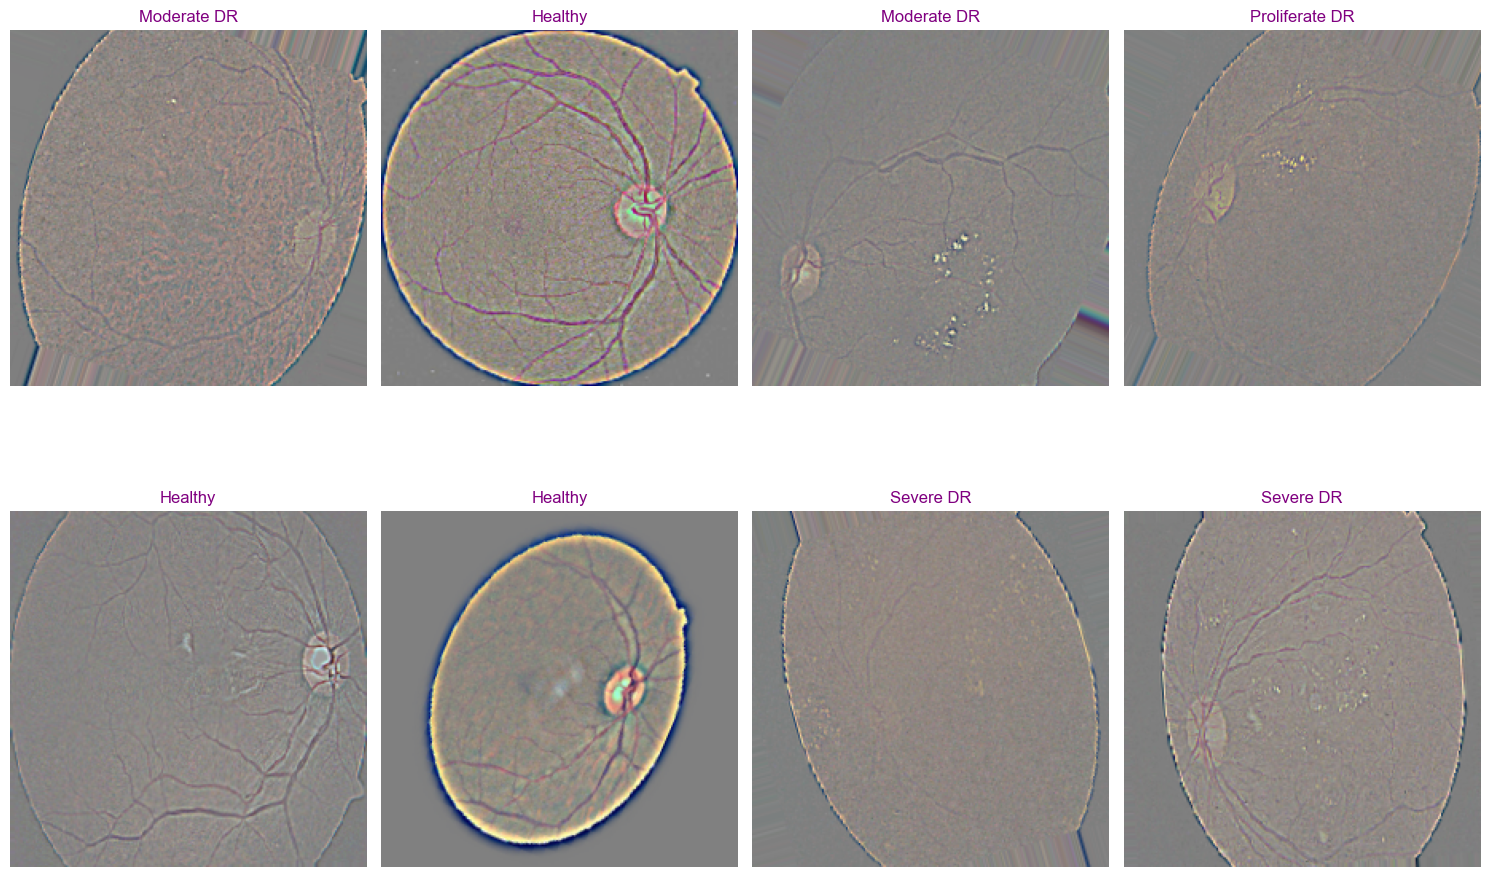

In [ ]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate



In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [ ]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
epochs = 100
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/100
110/110 [==============================] - 806s 7s/step - loss: 1.7680 - acc: 0.4941 - val_loss: 1.4776 - val_acc: 0.5345
Epoch 2/100
110/110 [==============================] - 554s 5s/step - loss: 1.2616 - acc: 0.5514 - val_loss: 1.1580 - val_acc: 0.5927
Epoch 3/100
110/110 [==============================] - 507s 4s/step - loss: 1.0882 - acc: 0.6027 - val_loss: 1.0572 - val_acc: 0.6291
Epoch 4/100
110/110 [==============================] - 486s 4s/step - loss: 0.9918 - acc: 0.6268 - val_loss: 1.0004 - val_acc: 0.6545
Epoch 5/100
110/110 [==============================] - 468s 4s/step - loss: 0.9358 - acc: 0.6468 - val_loss: 0.9135 - val_acc: 0.6691
Epoch 6/100
110/110 [==============================] - 473s 4s/step - loss: 0.8928 - acc: 0.6641 - val_loss: 0.8797 - val_acc: 0.6945
Epoch 7/100
110/110 [==============================] - 467s 4s/step - loss: 0.8322 - acc: 0.6859 - val_loss: 0.8499 - val_acc: 0.7018
Epoch 8/100
110/110 [==============================] - 670s 6s

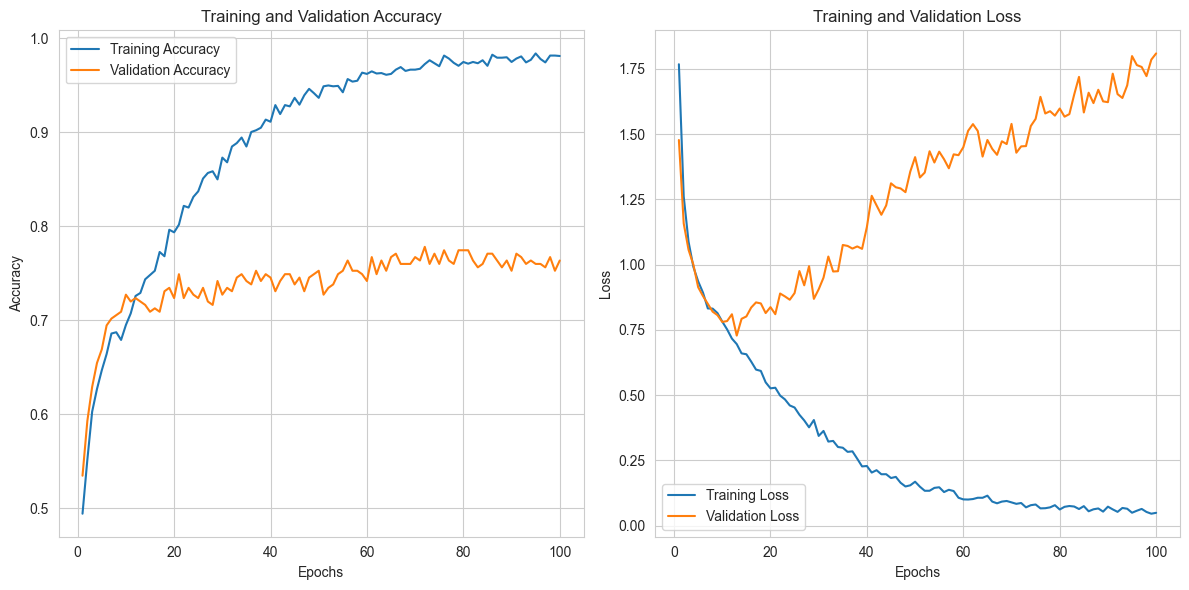

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation accuracy and loss from the history object
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating subplots for accuracy and loss
plt.figure(figsize=(12, 6))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Displaying the plots
plt.tight_layout()
plt.show()


Max Training Accuracy: 0.9840909242630005
Max Validation Accuracy: 0.778181791305542
Max Training Loss: 1.76800537109375
Max Validation Loss: 1.809503436088562


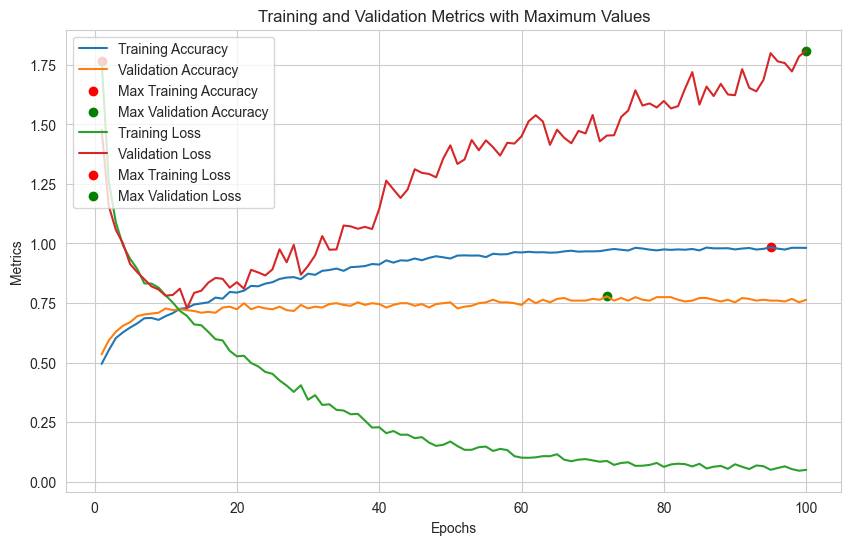

In [ ]:
import matplotlib.pyplot as plt

# Extracting the training and validation accuracy and loss from the history object
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Finding maximum values
max_training_accuracy = max(training_accuracy)
max_validation_accuracy = max(validation_accuracy)
max_training_loss = max(training_loss)
max_validation_loss = max(validation_loss)

# Printing maximum values
print("Max Training Accuracy:", max_training_accuracy)
print("Max Validation Accuracy:", max_validation_accuracy)
print("Max Training Loss:", max_training_loss)
print("Max Validation Loss:", max_validation_loss)

# Plotting the maximum values
plt.figure(figsize=(10, 6))

# Plotting max training accuracy and validation accuracy
plt.plot(range(1, epochs + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.scatter(training_accuracy.index(max_training_accuracy) + 1, max_training_accuracy, color='red', label='Max Training Accuracy')
plt.scatter(validation_accuracy.index(max_validation_accuracy) + 1, max_validation_accuracy, color='green', label='Max Validation Accuracy')

# Plotting max training loss and validation loss
plt.plot(range(1, epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss')
plt.scatter(training_loss.index(max_training_loss) + 1, max_training_loss, color='red', label='Max Training Loss')
plt.scatter(validation_loss.index(max_validation_loss) + 1, max_validation_loss, color='green', label='Max Validation Loss')

plt.title('Training and Validation Metrics with Maximum Values')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


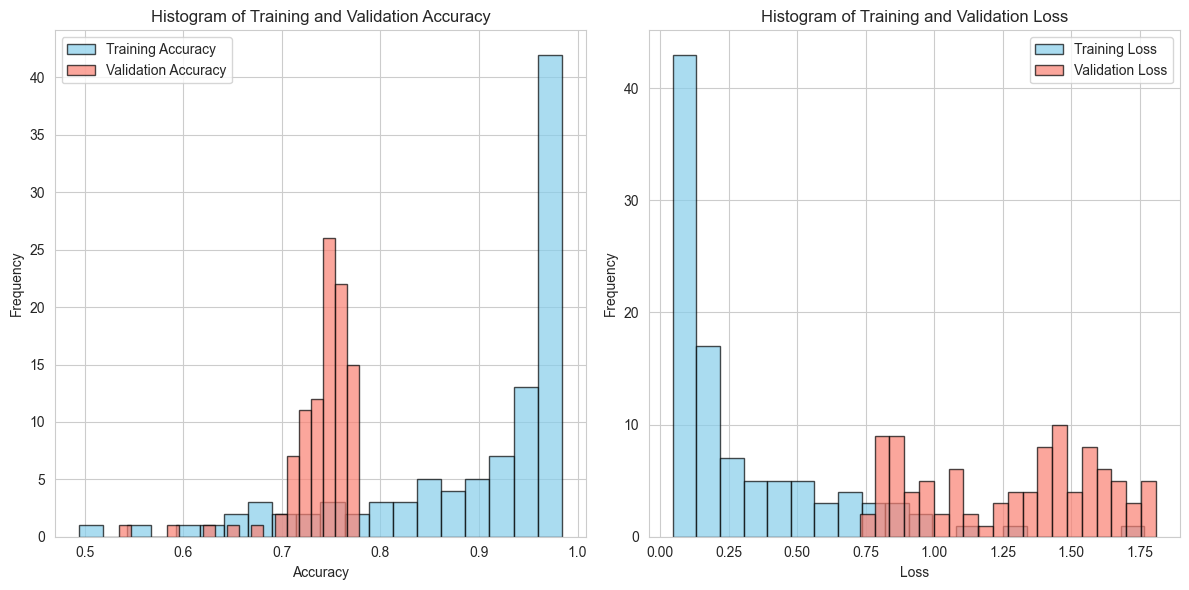

In [ ]:
import matplotlib.pyplot as plt

# Data
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating histogram for training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(training_accuracy, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Training Accuracy')
plt.hist(validation_accuracy, bins=20, color='salmon', edgecolor='black', alpha=0.7, label='Validation Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Training and Validation Accuracy')
plt.legend()

# Creating histogram for training and validation loss
plt.subplot(1, 2, 2)
plt.hist(training_loss, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Training Loss')
plt.hist(validation_loss, bins=20, color='salmon', edgecolor='black', alpha=0.7, label='Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


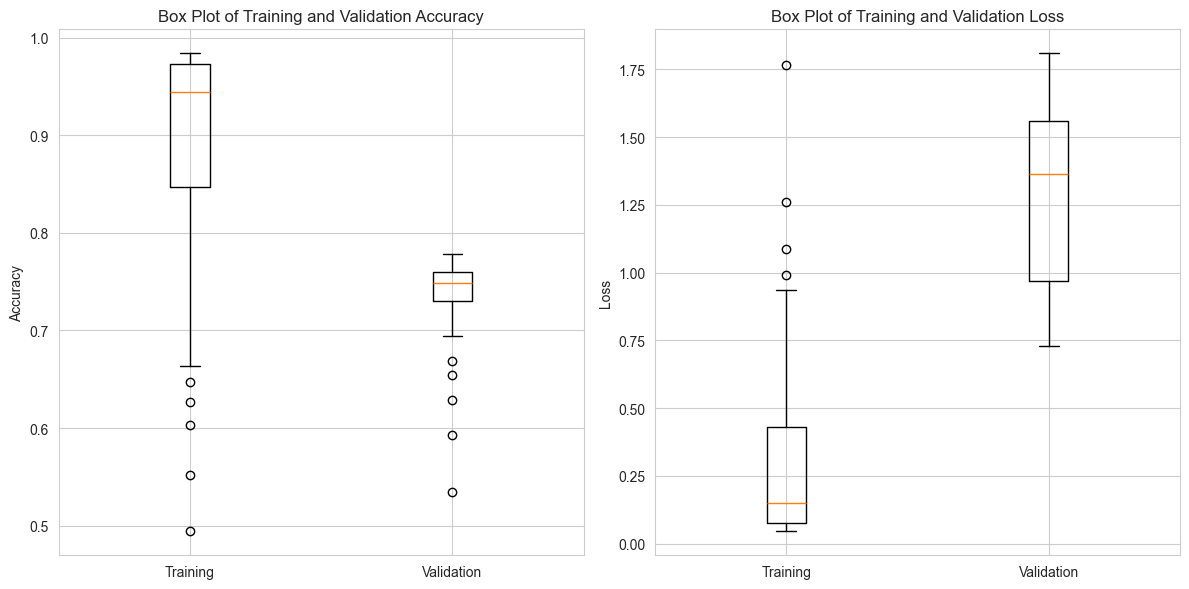

In [ ]:
import matplotlib.pyplot as plt

# Data
accuracy_data = [training_accuracy, validation_accuracy]
loss_data = [training_loss, validation_loss]

# Creating box plots for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(accuracy_data, labels=['Training', 'Validation'])
plt.title('Box Plot of Training and Validation Accuracy')
plt.ylabel('Accuracy')

# Creating box plots for loss
plt.subplot(1, 2, 2)
plt.boxplot(loss_data, labels=['Training', 'Validation'])
plt.title('Box Plot of Training and Validation Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


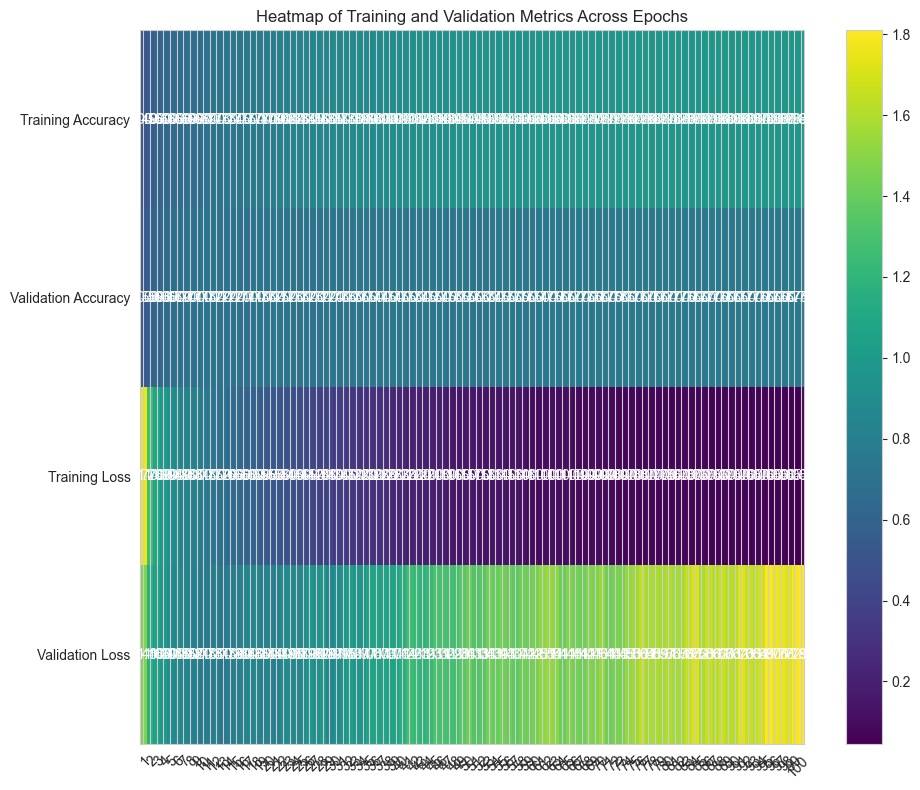

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
epochs = range(1, len(training_accuracy) + 1)
accuracy_loss_data = np.array([training_accuracy, validation_accuracy, training_loss, validation_loss])

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heatmap
heatmap = ax.imshow(accuracy_loss_data, cmap='viridis', aspect='auto')

# Set labels
ax.set_xticks(np.arange(len(epochs)))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(epochs)
ax.set_yticklabels(['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(epochs)):
    for j in range(4):
        text = ax.text(i, j, "{:.2f}".format(accuracy_loss_data[j, i]), ha="center", va="center", color="w")

# Set title and show plot
ax.set_title("Heatmap of Training and Validation Metrics Across Epochs")
fig.tight_layout()
plt.colorbar(heatmap)
plt.show()
